<a href="https://colab.research.google.com/github/CostaA6/DataScienceShowcase/blob/main/Seismic_Interpreter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Interpretación de sismicas de reflexión en 2D**

## Directorios de imagenes: Sismicas - Interpretaciones

Los directoriso estan separados en dos partes, datos de entrenamiento y datos de validación. A su vez cada uno contiene en directorios separados, sismicas y fallas interpretadas.

In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# Directorios donde están las imágenes de entrenamiento y validación
seis_dir = "/content/drive/MyDrive/Aprendizaje de Maquina/PROYECTO FINAL/2D_train/seis"
fault_dir = "/content/drive/MyDrive/Aprendizaje de Maquina/PROYECTO FINAL/2D_train/fault"

seis_val = "/content/drive/MyDrive/Aprendizaje de Maquina/PROYECTO FINAL/2D_validation/seis"
fault_val = "/content/drive/MyDrive/Aprendizaje de Maquina/PROYECTO FINAL/2D_validation/fault"

# Dimensiones de las imágenes después de redimensionarlas
IMG_SIZE = (128, 128)


## Carga y asignación de imagenes en directorios

In [ ]:
def load_images_from_folder(folder):
    images = []
    # Filtrar solo los archivos cuyo nombre es un número y ordenarlos
    file_names = sorted([f for f in os.listdir(folder) if f.split('.')[0].isdigit()], key=lambda x: int(x.split('.')[0]))
    for filename in file_names:
        img_path = os.path.join(folder, filename)
        # Cargar imagen en escala de grises y redimensionar a IMG_SIZE
        img = load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
        img_array = img_to_array(img) / 255.0  # Normalizar valores entre 0 y 1
        images.append(img_array)
    return np.array(images)

# Cargar datos de entrenamiento
seismic_images = load_images_from_folder(seis_dir)  # Imágenes sísmicas
fault_labels = load_images_from_folder(fault_dir)  # Fallas

# Cargar datos de validación
seismic_images_val = load_images_from_folder(seis_val)
fault_labels_val = load_images_from_folder(fault_val)

# Verificar dimensiones
print("Shape de sísmicas:", seismic_images.shape)  # (número de imágenes, 128, 128, 1)
print("Shape de fallas:", fault_labels.shape)      # (número de imágenes, 128, 128, 1)

# Asignar datos cargados
X_train, y_train = seismic_images, fault_labels
X_val, y_val = seismic_images_val, fault_labels_val


Shape de sísmicas: (2600, 128, 128, 1)
Shape de fallas: (2600, 128, 128, 1)


## Data Augmentation

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models

BATCH_SIZE = 16  # Tamaño de lote (puedes ajustarlo según la memoria de tu GPU)
SEED = 42        # Semilla para asegurar reproducibilidad

# Función para convertir imágenes de un canal a tres canales (RGB)
def to_rgb(images):
    return np.repeat(images, 3, axis=-1)  # Repite el canal único 3 veces

def add_noise(img):
    #noise = np.random.normal(0, 0.005, img.shape)  # Ruido gaussiano
    noise = 0
    img = img + noise
    return np.clip(img, 0.0, 1.0)  # Mantén los valores entre 0 y 1

# Convertir los conjuntos de entrenamiento y validación a RGB
X_train_rgb = to_rgb(X_train)
X_val_rgb = to_rgb(X_val)

image_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=add_noise  # Aplica la función de ruido
)

label_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=add_noise  # Aplica la función de ruido
)

# Ajustar los generadores
image_datagen.fit(X_train_rgb)
label_datagen.fit(y_train)

# Generador combinado para entrenamiento
def combined_generator(image_gen, label_gen):
    for img_batch, label_batch in zip(image_gen, label_gen):
        yield img_batch, label_batch

train_generator = combined_generator(
    image_datagen.flow(X_train_rgb, batch_size=BATCH_SIZE, seed=SEED),
    label_datagen.flow(y_train, batch_size=BATCH_SIZE, seed=SEED)
)

# Generador combinado para validación (sin augmentación)
val_generator = combined_generator(
    ImageDataGenerator().flow(X_val_rgb, batch_size=BATCH_SIZE, seed=SEED),
    ImageDataGenerator().flow(y_val, batch_size=BATCH_SIZE, seed=SEED)
)


## Definición del Modelo U-Net

Este código implementa un modelo U-Net para tareas de segmentación de imágenes. El modelo incluye un **encoder** para extraer características, un **bottleneck** para procesarlas, y un **decoder** para reconstruir la salida segmentada.


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, Model
from tensorflow.keras.regularizers import l1

def build_reduced_unet(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas del encoder preentrenado
    for layer in base_model.layers:
        layer.trainable = False

    # Encoder
    c1 = base_model.get_layer('block1_conv2').output
    c2 = base_model.get_layer('block2_conv2').output
    c3 = base_model.get_layer('block3_conv3').output
    c4 = base_model.get_layer('block4_conv3').output
    c5 = base_model.get_layer('block5_conv3').output

    # Bottleneck
    b1 = layers.Conv2D(256, (3, 3), padding='same')(c5)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)
    b1 = layers.Dropout(0.3)(b1)
    b1 = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(b1)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.Activation('relu')(b1)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b1)
    u1 = layers.concatenate([u1, c4])
    c6 = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(u1)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Activation('relu')(c6)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = layers.concatenate([u2, c3])
    c7 = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(u2)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(c7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Activation('relu')(c7)

    u3 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u3 = layers.concatenate([u3, c2])
    c8 = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(u3)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(c8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Activation('relu')(c8)

    u4 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u4 = layers.concatenate([u4, c1])
    c9 = layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(u4)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), padding='same', kernel_regularizer=l1(0.00001))(c9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Activation('relu')(c9)

    # Output Layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=base_model.input, outputs=outputs)

# Crear modelo reducido
input_shape = (128, 128, 3)
model = build_reduced_unet(input_shape)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 128, 128, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 64, 64, 64)     │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 64, 64, 128)    │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 64, 64, 128)    │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 32, 32, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 32, 32, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 32, 32, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 16, 16, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 16, 16, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 16, 16, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 8, 8, 512)      │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 8, 8, 512)      │      2,359,808 │ block5_conv1[0][0]     │
├──────────────────────

 Total params: 17,838,497 (68.05 MB)

 Trainable params: 3,121,825 (11.91 MB)

 Non-trainable params: 14,716,672 (56.14 MB)

## Entrenamiento del modelo

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import tensorflow as tf

# **Compilación del modelo**
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamiento del modelo
with tf.device('/GPU:0'):  # Usar GPU
    history = model.fit(
        train_generator,                  # Generador de entrenamiento
        validation_data=val_generator,   # Generador de validación
        epochs=15,                       # Número de épocas
        steps_per_epoch=len(X_train) // BATCH_SIZE,  # Pasos por época
        validation_steps=len(X_val) // BATCH_SIZE,   # Pasos para validación
        verbose=1                        # Mostrar progreso
    )

# Guardar el modelo
model.save("modelo_sismica_fallas.h5")
print("Modelo guardado como modelo_sismica_fallas.h5")


Epoch 1/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 63s 227ms/step - accuracy: 0.2419 - loss: 1.2104 - val_accuracy: 0.2847 - val_loss: 0.9413
Epoch 2/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.7506 - loss: 0.7006 - val_accuracy: 0.8658 - val_loss: 0.5897
Epoch 3/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8759 - loss: 0.5303 - val_accuracy: 0.9202 - val_loss: 0.4429
Epoch 4/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8876 - loss: 0.4617 - val_accuracy: 0.9205 - val_loss: 0.4244
Epoch 5/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 111ms/step - accuracy: 0.8919 - loss: 0.4175 - val_accuracy: 0.9322 - val_loss: 0.3627
Epoch 6/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.8949 - loss: 0.3840 - val_accuracy: 0.9379 - val_loss: 0.2844
Epoch 7/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.8988 - loss: 0.3546 - val_accuracy: 0.9384 - val_loss: 0.2581
Epoch 8/15
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 112ms/step - accuracy: 0.9018 - loss: 0

Modelo guardado como modelo_sismica_fallas.h5


## Viazualización de entradas y salidas random

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


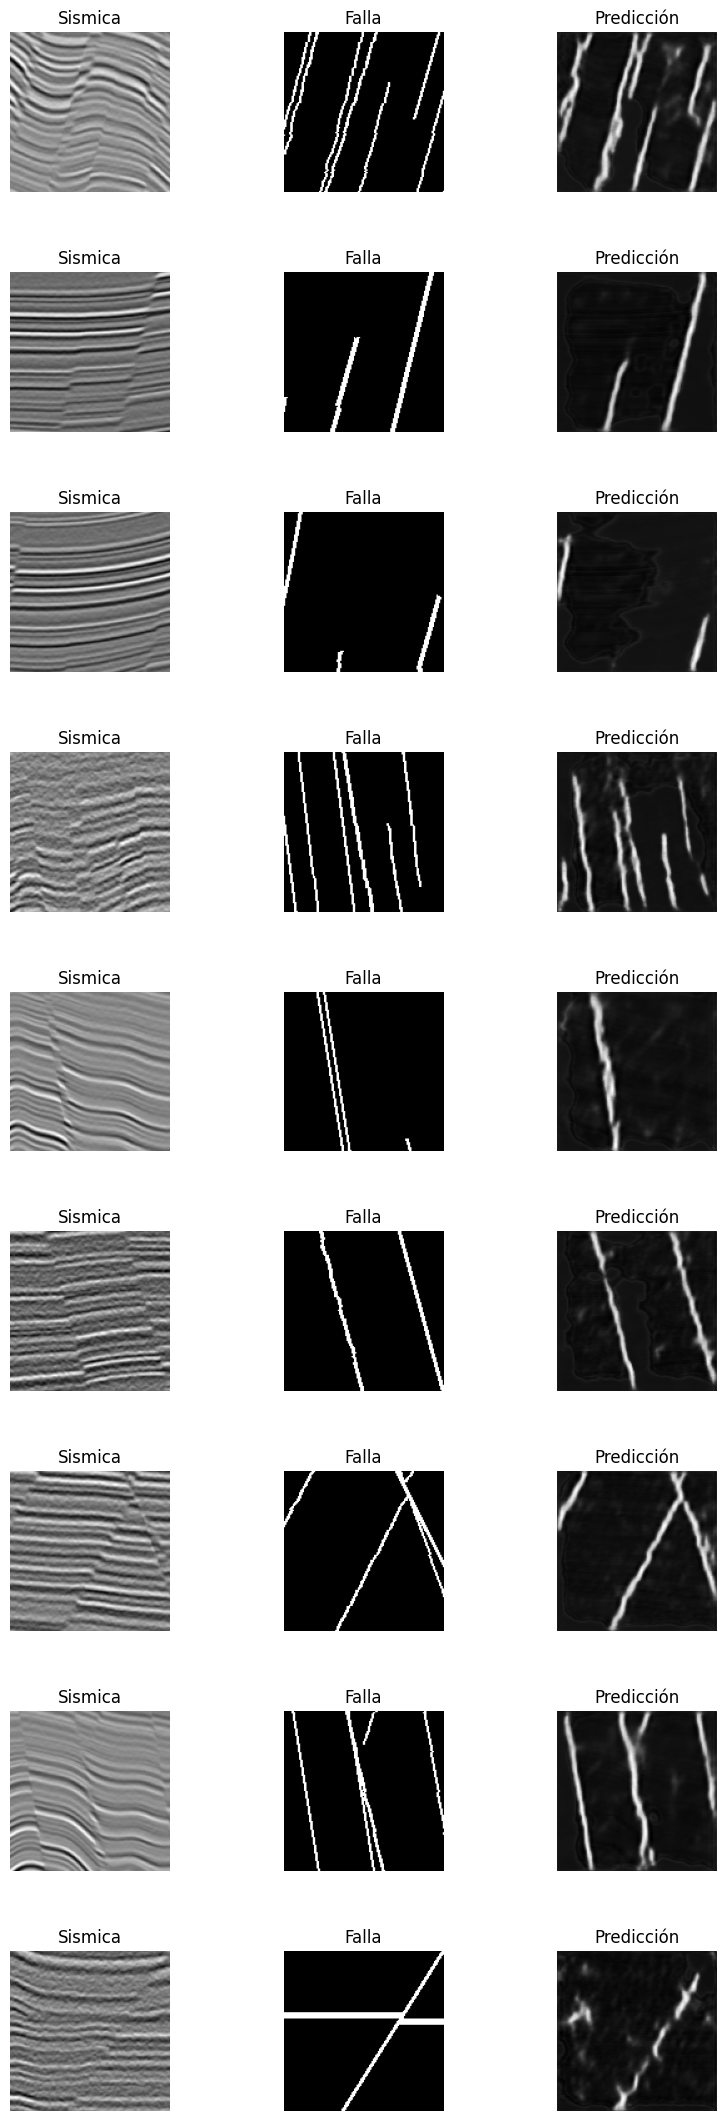

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Número de ejemplos a mostrar
num_examples = 9

# Obtener índices aleatorios para las imágenes de validación
random_indices = random.sample(range(len(X_val)), num_examples)

# Crear una figura para las imágenes
fig, axes = plt.subplots(num_examples, 3, figsize=(10, num_examples * 3))

# Ajustar el diseño para evitar superposición
plt.subplots_adjust(hspace=0.5)

for idx, i in enumerate(random_indices):
    # Sismica
    axes[idx, 0].imshow(X_val[i, :, :, 0], cmap='gray')
    axes[idx, 0].set_title('Sismica')
    axes[idx, 0].axis('off')

    # Falla
    axes[idx, 1].imshow(y_val[i, :, :, 0], cmap='gray')
    axes[idx, 1].set_title('Falla')
    axes[idx, 1].axis('off')

    # Predicción
    grayscale_image = X_val[i]  # Imagen en escala de grises
    rgb_image = np.repeat(grayscale_image, 3, axis=-1)  # Convertir a 3 canales
    prediction = model.predict(np.expand_dims(rgb_image, axis=0))
    axes[idx, 2].imshow(prediction[0, :, :, 0], cmap='gray')
    axes[idx, 2].set_title('Predicción')
    axes[idx, 2].axis('off')

# Mostrar la figura completa
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


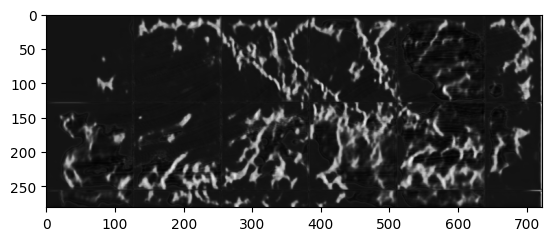

In [ ]:
# prompt: Aplica el modelo mediante parches a una imagen mas grande llamada asdasd.png. Dividila en parches de 128x128 y aplica el modelo, luego recontrui el resultado

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# Cargar el modelo
model = tf.keras.models.load_model("modelo_sismica_fallas.h5")

def predict_on_patches(image_path, patch_size=128):
    img = Image.open(image_path).convert("L")  # Convertir a escala de grises
    img_array = img_to_array(img) / 255.0

    height, width = img_array.shape[:2]
    patches = []
    positions = []

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = img_array[i:min(i + patch_size, height), j:min(j + patch_size, width)]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
              patches.append(patch)
              positions.append((i,j))
            else:
              # Manejar parches incompletos (rellenarlos con ceros)
              padded_patch = np.zeros((patch_size, patch_size, 1)) # Add channel dimension here
              padded_patch[:patch.shape[0], :patch.shape[1], :patch.shape[2]] = patch # Assign to all dimensions
              patches.append(padded_patch)
              positions.append((i,j))

    # Convertir a RGB
    patches_rgb = np.repeat(np.array(patches), 3, axis=-1) # Move repeat outside

    predictions = model.predict(patches_rgb)

    reconstructed_image = np.zeros((height, width))
    for k in range(len(predictions)):
        i, j = positions[k]
        reconstructed_image[i:min(i + patch_size, height), j:min(j + patch_size, width)] = predictions[k, :, :, 0][:min(patch_size, height-i), :min(patch_size, width-j)]

    return reconstructed_image

# Aplicar a la imagen
reconstructed_image = predict_on_patches("asdasd.png")

# Visualizar la imagen reconstruida
import matplotlib.pyplot as plt
plt.imshow(reconstructed_image, cmap="gray")
plt.show()

# Guardar la imagen reconstruida
plt.imsave("asdasd_predicted.png", reconstructed_image, cmap="gray")

# Implementación en dato pseudo-real

## Implementacion por parches

Implemento el modelo en "parches" de 128x128 y luego los concateno para graficar el reultado final.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

<ipython-input-8-d29581ec1c39>:27: RuntimeWarning: invalid value encountered in divide
  return reconstructed_image / weight_matrix  # Promediar valores en las regiones de solapamiento


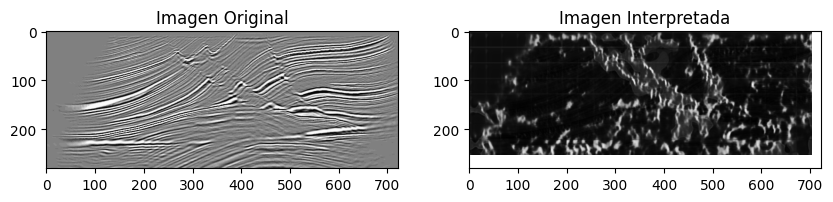

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array # Import necessary functions
import matplotlib.pyplot as plt # Import matplotlib for plotting


def divide_into_patches_with_overlap(image, patch_size, step):
    """Divide una imagen en parches con solapamiento."""
    h, w = image.shape[:2]  # Get the first two dimensions (height and width)
    patches = []
    positions = []  # Guardar las posiciones (i, j) de cada parche
    for i in range(0, h - patch_size + 1, step):
        for j in range(0, w - patch_size + 1, step):
            patch = image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            positions.append((i, j))
    return np.array(patches), positions

def reconstruct_from_patches_with_overlap(patches, positions, image_shape, patch_size, step):
    """Reconstruye la imagen a partir de parches con solapamiento."""
    # image_shape might have more than 2 dimensions, so use slicing to get the first 2
    h, w = image_shape[:2]
    reconstructed_image = np.zeros((h, w))
    weight_matrix = np.zeros((h, w))  # Para promediar los solapamientos
    for patch, (i, j) in zip(patches, positions):
        reconstructed_image[i:i+patch_size, j:j+patch_size] += patch
        weight_matrix[i:i+patch_size, j:j+patch_size] += 1
    return reconstructed_image / weight_matrix  # Promediar valores en las regiones de solapamiento

# Define the load_and_preprocess_image function
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image."""
    img = load_img(image_path, color_mode="grayscale")  # Load image in grayscale
    img_array = img_to_array(img) / 255.0  # Convert to array and normalize

    # Convert single-channel grayscale to 3-channel RGB by repeating the grayscale image
    img_array_rgb = np.repeat(img_array, 3, axis=-1)

    return img_array_rgb

# Define the plot_results function
def plot_results(original_image, interpreted_image):
    """Plots the original and interpreted images."""
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(1, 2, 2)
    plt.imshow(interpreted_image, cmap='gray')
    plt.title('Imagen Interpretada')
    plt.show()


# Aplicar modelo con parches superpuestos
def apply_model_with_overlap(image_path, model_path, patch_size=128, step=32):
    """Aplica un modelo a una imagen grande usando parches con solapamiento."""
    # Cargar el modelo entrenado
    model = load_model(model_path)  # Now 'load_model' is defined

    # Cargar y normalizar la imagen
    image = load_and_preprocess_image(image_path)

    # Dividir en parches con solapamiento
    patches, positions = divide_into_patches_with_overlap(image, patch_size, step)

    # Procesar los parches con el modelo
    patches_predicted = np.array([model.predict(patch[np.newaxis, ..., np.newaxis])[0, ..., 0] for patch in patches])

    # Recomponer la imagen predicha
    interpreted_image = reconstruct_from_patches_with_overlap(patches_predicted, positions, image.shape, patch_size, step)

    # Graficar resultados
    plot_results(image, interpreted_image) # Assuming plot_results is defined elsewhere

# Ejecutar con una imagen

# Ejecutar con una imagen grande
IMAGE_PATH = "/content/asdasd.png"  # Cambiar a la ruta de tu imagen
MODEL_PATH= "modelo_sismica_fallas.h5"  # Cambiar a la ruta de tu modelo
apply_model_with_overlap(IMAGE_PATH, MODEL_PATH, patch_size=128, step=32)

## Control de calidad en parches

Visualizo como se implementa el modelo en parches de la imagen original para revizar como trabaja.

In [ ]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Asegúrate de que MODEL_PATH apunte al modelo correcto
MODEL_PATH = "modelo_sismica_fallas.h5"

def load_and_preprocess_image(image_path):
    img = load_img(image_path, color_mode="grayscale")
    img_array = img_to_array(img) / 255.0
    return img_array

def plot_results(original_image, interpreted_image):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(1, 2, 2)
    plt.imshow(interpreted_image, cmap='gray')
    plt.title('Imagen Interpretada')
    plt.show()


def apply_model_to_random_patches(image_path, model_path, num_patches=3, patch_size=128):
    # Cargar el modelo
    model = load_model(model_path)

    # Cargar la imagen
    img = load_and_preprocess_image(image_path)
    h, w = img.shape[:2]

    for _ in range(num_patches):
        # Generar coordenadas aleatorias para el parche
        x = random.randint(0, h - patch_size)
        y = random.randint(0, w - patch_size)

        # Extraer el parche
        patch = img[x:x + patch_size, y:y + patch_size]

        # Predecir con el modelo (añadir dimensión de lote y canal)
        patch_input = np.expand_dims(patch, axis=(0, -1))
        prediction = model.predict(patch_input)[0, :, :, 0]

        # Mostrar los resultados
        fig, axes = plt.subplots(1, 2, figsize=(9, 3))

        axes[0].imshow(patch, cmap='gray')
        axes[0].set_title('Parche Original')
        axes[0].axis('off')

        axes[1].imshow(prediction, cmap='gray')  # Mostrar la predicción
        axes[1].set_title('Predicción')
        axes[1].axis('off')


# Ejemplo de uso:
apply_model_to_random_patches("/content/asdasd.png", MODEL_PATH)

ValueError: Input 0 of layer "functional" is incompatible with the layer: expected shape=(None, 128, 128, 3), found shape=(1, 128, 128, 1)

## Implementacion por downscaling

Implemento el modelo modificando la resolucion de la imagen de entrada y aplico el modelo generado, luego vuelvo a las dimenciones originales.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


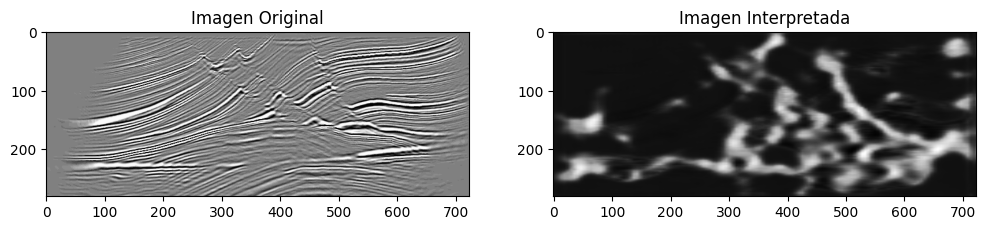

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize  # Para redimensionar imágenes
import numpy as np
import matplotlib.pyplot as plt


def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image."""
    img = load_img(image_path, color_mode="rgb")  # Load image in RGB
    img_array = img_to_array(img) / 255.0  # Convert to array and normalize
    return img_array


def resize_image(image, target_size):
    """Redimensionar una imagen."""
    return resize(image, target_size, anti_aliasing=True, mode='reflect')


def plot_results(original_image, interpreted_image):
    """Graficar la imagen original y la salida interpretada."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Imagen Original')

    plt.subplot(1, 2, 2)
    plt.imshow(interpreted_image, cmap='gray')
    plt.title('Imagen Interpretada')
    plt.show()


def apply_model_with_downscaling(image_path, model_path, target_size=(128, 128)):
    """Aplicar un modelo a una imagen reduciendo la resolución."""
    # Cargar el modelo entrenado
    model = load_model(model_path)

    # Cargar y normalizar la imagen
    image = load_and_preprocess_image(image_path)
    original_shape = image.shape  # Guardar la forma original

    # Redimensionar la imagen
    downscaled_image = resize_image(image, target_size)

    # Añadir dimensiones para la entrada al modelo
    downscaled_image_expanded = np.expand_dims(downscaled_image, axis=0)  # Add batch dimension

    # Hacer la predicción con el modelo
    prediction = model.predict(downscaled_image_expanded)[0, ..., 0]

    # Escalar la salida al tamaño original
    upscaled_prediction = resize_image(prediction, original_shape[:2])  # Resize to original height and width

    # Graficar los resultados
    plot_results(image, upscaled_prediction)


# Ejecutar con una imagen
IMAGE_PATH = "/content/asdasd.png"  # Cambia esto a la ruta de tu imagen
MODEL_PATH = "modelo_sismica_fallas.h5"  # Cambia esto a la ruta de tu modelo
apply_model_with_downscaling(IMAGE_PATH, MODEL_PATH, target_size=(128, 128))


## Solucion mixta

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step


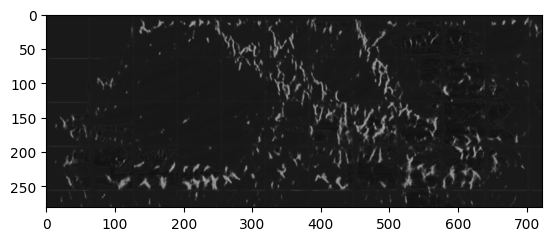

In [ ]:
# prompt: QUiero un codigo que implemente el modelo sobre la imagen asdasd.png  , pero que lo haga en parches 256x256 a los que previamente se les redujo la resolucion a 128x128. Luego la prediccion es unida para formar la imagen completa

import tensorflow as tf
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.transform import resize
import matplotlib.pyplot as plt

# Cargar el modelo (asegúrate de que la ruta sea correcta)
model = tf.keras.models.load_model("modelo_sismica_fallas.h5")

def predict_on_patches(image_path, patch_size=64, downscale_size=128):
    img = Image.open(image_path).convert("RGB")
    img_array = img_to_array(img) / 255.0
    original_height, original_width = img_array.shape[:2]

    patches = []
    positions = []

    for i in range(0, original_height, patch_size):
        for j in range(0, original_width, patch_size):
            patch = img_array[i:min(i + patch_size, original_height), j:min(j + patch_size, original_width)]
            # Resize the patch
            resized_patch = resize(patch, (downscale_size, downscale_size), anti_aliasing=True, mode='reflect')
            patches.append(resized_patch)
            positions.append((i, j))


    predictions = model.predict(np.array(patches))

    # Reconstruir la imagen
    reconstructed_image = np.zeros((original_height, original_width, 3))
    for k in range(len(predictions)):
        i, j = positions[k]
        # Resize the prediction back to the original patch size
        upscaled_prediction = resize(predictions[k], (patch_size, patch_size), anti_aliasing=True, mode='reflect')
        reconstructed_image[i:min(i + patch_size, original_height), j:min(j + patch_size, original_width)] = upscaled_prediction[:min(patch_size, original_height - i), :min(patch_size, original_width - j)]

    return reconstructed_image


# Aplicar a la imagen
reconstructed_image = predict_on_patches("asdasd.png")

# Visualizar la imagen reconstruida
plt.imshow(reconstructed_image)
plt.show()

# Guardar la imagen reconstruida
plt.imsave("asdasd_predicted.png", reconstructed_image)

Transfere learning
